In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np

In [2]:
@dataclass
class Camera:
    baseline: int = 100  # ADU
    bit_depth: int = 12
    dark_noise: float = 6.83  # e-
    gain: float = 0.12  # ADU / e-
    quantum_efficiency: float = 0.76
    well_capacity: int = 32406  # e-
    rng: np.random.Generator = np.random.default_rng()

    def snap(self, signal):
        # Simulate shot noise and convert to electrons
        photoelectrons = self.rng.poisson(
            self.quantum_efficiency * signal, size=signal.shape
        )

        # Add dark noise
        electrons = (
            self.rng.normal(scale=self.dark_noise, size=photoelectrons.shape)
            + photoelectrons
        )

        # Clip to the well capacity to model electron saturation
        electrons = np.clip(electrons, 0, self.well_capacity)

        # Convert to ADU
        adu = electrons * self.gain + self.baseline

        # Clip to the bit depth to model ADU saturation
        adu = np.clip(adu, 0, 2 ** self.bit_depth - 1)

        return adu.astype(np.uint16)

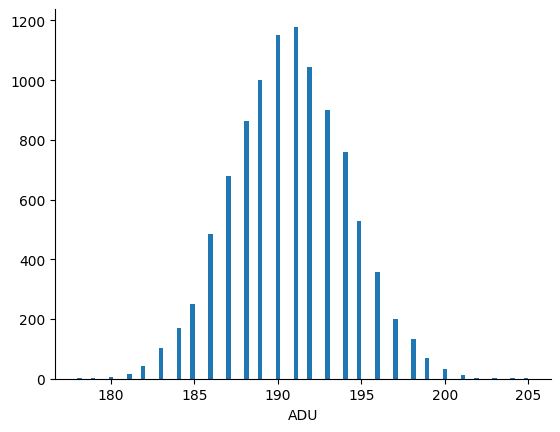

In [5]:
camera = Camera()
results = camera.snap(np.ones((10000)) * 1000)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(results, bins=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("ADU")
plt.show()

In [6]:
print(results.mean())
print(results.std())

190.721
3.4368239698884784


In [9]:
mu_y = camera.gain * camera.quantum_efficiency * 1000 + camera.baseline
sigma_y = np.sqrt(
    camera.gain ** 2 * camera.dark_noise ** 2 + 1/12 + camera.gain * (mu_y - camera.baseline)
)

print(mu_y)
print(sigma_y)

191.2
3.4203914239942383
